In [11]:
using Random, Statistics
using ITensors, ITensorMPS, ITensorCorrelators
using Plots

In [12]:
import Base: cat
const _cat_orig = cat
function cat(ts...; dims)
  return _cat_orig(ts...; dim=dims)
end

function create_weak_measurement_operators(sites, lambda_x::Float64, lambda_zz::Float64)
    WEAK_X_0 = Dict{Int,ITensor}()
    WEAK_X_1 = Dict{Int,ITensor}()
    WEAK_ZZ_0 = Dict{Tuple{Int,Int},ITensor}()
    WEAK_ZZ_1 = Dict{Tuple{Int,Int},ITensor}()

    norm_x  = sqrt(2 * (1 + lambda_x^2))
    norm_zz = sqrt(2 * (1 + lambda_zz^2))

    for i in 1:length(sites)
        Id_i = op("Id", sites[i])
        X_i  = 2 * op("Sx", sites[i])
        WEAK_X_0[i] = (Id_i + lambda_x * X_i) / norm_x
        WEAK_X_1[i] = (Id_i - lambda_x * X_i) / norm_x
    end
    for i in 1:(length(sites)-1)
        Z_i = 2 * op("Sz", sites[i])
        Z_j = 2 * op("Sz", sites[i+1])
        II  = op("Id", sites[i]) * op("Id", sites[i+1])
        ZZ  = Z_i * Z_j
        WEAK_ZZ_0[(i,i+1)] = (II + lambda_zz * ZZ) / norm_zz
        WEAK_ZZ_1[(i,i+1)] = (II - lambda_zz * ZZ) / norm_zz
    end
    return WEAK_X_0, WEAK_X_1, WEAK_ZZ_0, WEAK_ZZ_1
end

function create_up_state_mps(L::Int)
    sites = siteinds("S=1/2", L)
    ψ = productMPS(sites, fill("Up", L))
    return ψ, sites
end

function sample_and_apply(ψ::MPS, K0::ITensor, K1::ITensor, which::Vector{Int};
                          maxdim::Int=256, cutoff::Float64=1e-12, rng=Random.GLOBAL_RNG)
    ϕ0 = product(K0, ψ, which; maxdim=maxdim, cutoff=cutoff)
    p0 = max(real(inner(dag(ϕ0), ϕ0)), 0.0)
    ϕ1 = product(K1, ψ, which; maxdim=maxdim, cutoff=cutoff)
    p1 = max(real(inner(dag(ϕ1), ϕ1)), 0.0)
    tot = p0 + p1
    ϕ = (tot <= 0) ? ϕ0 : (rand(rng) < p0/tot ? ϕ0 : ϕ1)
    orthogonalize!(ϕ, which[end])
    normalize!(ϕ)
    return ϕ
end

# One trajectory, open chain, T_max = 2L
function evolve_one_trial(L::Int; lambda_x::Float64, lambda_zz::Float64,
                          maxdim::Int=256, cutoff::Float64=1e-12, rng=Random.GLOBAL_RNG)
    ψ, sites = create_up_state_mps(L)
    KX0, KX1, KZZ0, KZZ1 = create_weak_measurement_operators(sites, lambda_x, lambda_zz)
    T_max = 2L
    for _ in 1:T_max
        # weak X on all sites
        for i in 1:L
            ψ = sample_and_apply(ψ, KX0[i], KX1[i], [i]; maxdim=maxdim, cutoff=cutoff, rng=rng)
        end
        # weak ZZ brickwork: even, then odd bonds
        for i in 1:2:(L-1)
            ψ = sample_and_apply(ψ, KZZ0[(i,i+1)], KZZ1[(i,i+1)], [i,i+1];
                                 maxdim=maxdim, cutoff=cutoff, rng=rng)
        end
        for i in 2:2:(L-1)
            ψ = sample_and_apply(ψ, KZZ0[(i,i+1)], KZZ1[(i,i+1)], [i,i+1];
                                 maxdim=maxdim, cutoff=cutoff, rng=rng)
        end
    end
    return ψ, sites
end

# EA Binder with ITensorCorrelators (Spin-1/2 → use "Sz")
# B = 1 - S4/(3*S2^2),  S2=∑⟨Sz_i Sz_j⟩^2,  S4=∑⟨Sz_i Sz_j Sz_k Sz_l⟩^2
function ea_binder_parameter(ψ::MPS, sites; tol::Float64=1e-12,
                             chunk4::Int=50_000, eps::Float64=1e-30)
    L = length(sites)

    # 2-point
    pairs = [(i,j) for i in 1:L for j in 1:L]
    c2 = correlator(ψ, ("Sz","Sz"), pairs)
    S2 = 0.0
    for (i,j) in pairs
        v = real(c2[(i,j)])
        S2 += v*v
    end

    # 4-point (chunked)
    S4 = 0.0
    buf = NTuple{4,Int}[]
    function flush!()
        isempty(buf) && return
        c4 = correlator(ψ, ("Sz","Sz","Sz","Sz"), buf)
        for key in buf
            v = real(c4[key])
            S4 += v*v
        end
        empty!(buf)
    end
    for i in 1:L, j in 1:L, k in 1:L, l in 1:L
        push!(buf, (i,j,k,l))
        if length(buf) >= chunk4; flush!(); end
    end
    flush!()

    denom = max(3.0*S2*S2, eps)
    B = 1.0 - S4/denom
    return B
end

function ea_binder_mc(L::Int; lambda_x::Float64, lambda_zz::Float64,
                      ntrials::Int=200, maxdim::Int=256, cutoff::Float64=1e-12,
                      chunk4::Int=50_000, seed::Union{Nothing,Int}=nothing)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed)
    S2s = Vector{Float64}(undef, ntrials)
    S4s = Vector{Float64}(undef, ntrials)
    Bs  = Vector{Float64}(undef, ntrials)

    for t in 1:ntrials
        ψ, sites = evolve_one_trial(L; lambda_x=lambda_x, lambda_zz=lambda_zz,
                                    maxdim=maxdim, cutoff=cutoff, rng=rng)
        # compute S2,S4 once to form both EA-B and per-trial B
        # (reuse code to avoid recomputing correlators)
        Ls = length(sites)
        pairs = [(i,j) for i in 1:Ls for j in 1:Ls]
        c2 = correlator(ψ, ("Sz","Sz"), pairs)
        S2 = 0.0
        for (i,j) in pairs
            v = real(c2[(i,j)])
            S2 += v*v
        end
        # 4-point chunked
        S4 = 0.0
        buf = NTuple{4,Int}[]
        function flush!()
            isempty(buf) && return
            c4 = correlator(ψ, ("Sz","Sz","Sz","Sz"), buf)
            for key in buf
                v = real(c4[key]); S4 += v*v
            end
            empty!(buf)
        end
        for i in 1:Ls, j in 1:Ls, k in 1:Ls, l in 1:Ls
            push!(buf, (i,j,k,l))
            if length(buf) >= chunk4; flush!(); end
        end
        flush!()

        S2s[t] = S2
        S4s[t] = S4
        Bs[t]  = 1.0 - S4 / max(3.0*S2*S2, 1e-30)
    end

    S2_bar = mean(S2s)
    S4_bar = mean(S4s)
    B_EA   = 1.0 - S4_bar / (3.0*S2_bar^2 + 1e-30)

    return (B = B_EA,
            B_mean_of_trials = mean(Bs),
            B_std_of_trials  = std(Bs),
            S2_bar = S2_bar,
            S4_bar = S4_bar,
            ntrials = ntrials)
end

plot_binder_vs_lambda (generic function with 1 method)

In [13]:
using ProgressMeter

function calculate_binder_vs_lambda_with_progress(L::Int; lambdas = 0.0:0.05:1.0,
                                                 ntrials::Int=100, maxdim::Int=256, cutoff::Float64=1e-12,
                                                 chunk4::Int=50_000, seed::Union{Nothing,Int}=123)
    Bvals = Float64[]
    Bmean = Float64[]
    Bstd  = Float64[]
    
    p = Progress(length(lambdas), desc="L=$L: ")
    
    for (idx, λ) in enumerate(lambdas)
        λx  = λ
        λzz = 1.0 - λ
        
        res = ea_binder_mc(L; lambda_x=λx, lambda_zz=λzz, ntrials=ntrials,
                           maxdim=maxdim, cutoff=cutoff, chunk4=chunk4, seed=seed)
        push!(Bvals, res.B)
        push!(Bmean, res.B_mean_of_trials)
        push!(Bstd,  res.B_std_of_trials)
        
        println("L=$L, λ=$(round(λ, digits=3)): B = $(round(res.B, digits=6))")
        
        next!(p)
    end
    
    return (λs=collect(lambdas), B=Bvals, B_mean=Bmean, B_std=Bstd)
end


calculate_binder_vs_lambda_with_progress (generic function with 1 method)

In [14]:
L_values = [8, 10, 12]
lambdas_range = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]
ntrials_val = 100

results = Vector{Any}(undef, length(L_values))

Threads.@threads for i in 1:length(L_values)
    L = L_values[i]
    results[i] = calculate_binder_vs_lambda_with_progress(L; 
                                                         lambdas=lambdas_range, 
                                                         ntrials=ntrials_val, 
                                                         chunk4=80_000, 
                                                         seed=42 + i)
end

L=8, λ=0.3: B = 0.63159


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=10, λ=0.7: B = 0.168842


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=10, λ=0.7: B = 0.168842


L=12:  57%|█████████████████████████▊                   |  ETA: 0:10:39

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=10, λ=0.7: B = 0.168842


L=12:  57%|█████████████████████████▊                   |  ETA: 0:10:39

L=12, λ=0.5: B = 0.432689


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=10, λ=0.7: B = 0.168842


L=12:  57%|█████████████████████████▊                   |  ETA: 0:10:39

L=12, λ=0.5: B = 0.432689


L=12:  71%|████████████████████████████████▏            |  ETA: 0:06:49

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=10, λ=0.7: B = 0.168842


L=12:  57%|█████████████████████████▊                   |  ETA: 0:10:39

L=12, λ=0.5: B = 0.432689


L=12:  71%|████████████████████████████████▏            |  ETA: 0:06:49

L=12, λ=0.55: B = 0.334079


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=10, λ=0.7: B = 0.168842


L=12:  57%|█████████████████████████▊                   |  ETA: 0:10:39

L=12, λ=0.5: B = 0.432689


L=12:  71%|████████████████████████████████▏            |  ETA: 0:06:49

L=12, λ=0.55: B = 0.334079


L=12:  86%|██████████████████████████████████████▋      |  ETA: 0:03:19

L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=10, λ=0.7: B = 0.168842


L=12:  57%|█████████████████████████▊                   |  ETA: 0:10:39

L=12, λ=0.5: B = 0.432689


L=12:  71%|████████████████████████████████▏            |  ETA: 0:06:49

L=12, λ=0.55: B = 0.334079


L=12:  86%|██████████████████████████████████████▋      |  ETA: 0:03:19

L=12, λ=0.6: B = 0.253677


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=10, λ=0.7: B = 0.168842


L=12:  57%|█████████████████████████▊                   |  ETA: 0:10:39

L=12, λ=0.5: B = 0.432689


L=12:  71%|████████████████████████████████▏            |  ETA: 0:06:49

L=12, λ=0.55: B = 0.334079


L=12:  86%|██████████████████████████████████████▋      |  ETA: 0:03:19

L=12, λ=0.6: B = 0.253677


L=12: 100%|█████████████████████████████████████████████| Time: 0:22:42
L=12: 100%|█████████████████████████████████████████████| Time: 0:22:42


L=8, λ=0.3: B = 0.63159


L=8:  29%|█████████████▏                                |  ETA: 0:03:49

L=8, λ=0.4: B = 0.565842
L=10, λ=0.3: B = 0.643734
L=10, λ=0.3: B = 0.643734


L=8:  43%|███████████████████▊                          |  ETA: 0:03:03

L=8, λ=0.45: B = 0.515502


L=8:  57%|██████████████████████████▎                   |  ETA: 0:02:17

L=8, λ=0.5: B = 0.438442


L=8:  71%|████████████████████████████████▉             |  ETA: 0:01:31

L=8, λ=0.55: B = 0.384174
L=12, λ=0.3: B = 0.642672
L=12, λ=0.3: B = 0.642672


L=10:  29%|████████████▉                                |  ETA: 0:10:02

L=10, λ=0.4: B = 0.577544


L=8:  86%|███████████████████████████████████████▍      |  ETA: 0:00:45

L=8, λ=0.6: B = 0.312646


L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16
L=8: 100%|██████████████████████████████████████████████| Time: 0:05:16


L=8, λ=0.7: B = 0.205168


L=10:  43%|███████████████████▎                         |  ETA: 0:07:53

L=10, λ=0.45: B = 0.506587


L=12:  29%|████████████▉                                |  ETA: 0:18:50

L=12, λ=0.4: B = 0.564169


L=10:  57%|█████████████████████████▊                   |  ETA: 0:05:46

L=10, λ=0.5: B = 0.447189


L=10:  71%|████████████████████████████████▏            |  ETA: 0:03:46

L=10, λ=0.55: B = 0.362887


L=12:  43%|███████████████████▎                         |  ETA: 0:14:40

L=12, λ=0.45: B = 0.492432


L=10:  86%|██████████████████████████████████████▋      |  ETA: 0:01:52

L=10, λ=0.6: B = 0.284696


L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53
L=10: 100%|█████████████████████████████████████████████| Time: 0:12:53


L=10, λ=0.7: B = 0.168842


L=12:  57%|█████████████████████████▊                   |  ETA: 0:10:39

L=12, λ=0.5: B = 0.432689


L=12:  71%|████████████████████████████████▏            |  ETA: 0:06:49

L=12, λ=0.55: B = 0.334079


L=12:  86%|██████████████████████████████████████▋      |  ETA: 0:03:19

L=12, λ=0.6: B = 0.253677


L=12: 100%|█████████████████████████████████████████████| Time: 0:22:42
L=12: 100%|█████████████████████████████████████████████| Time: 0:22:42


L=12, λ=0.7: B = 0.137688


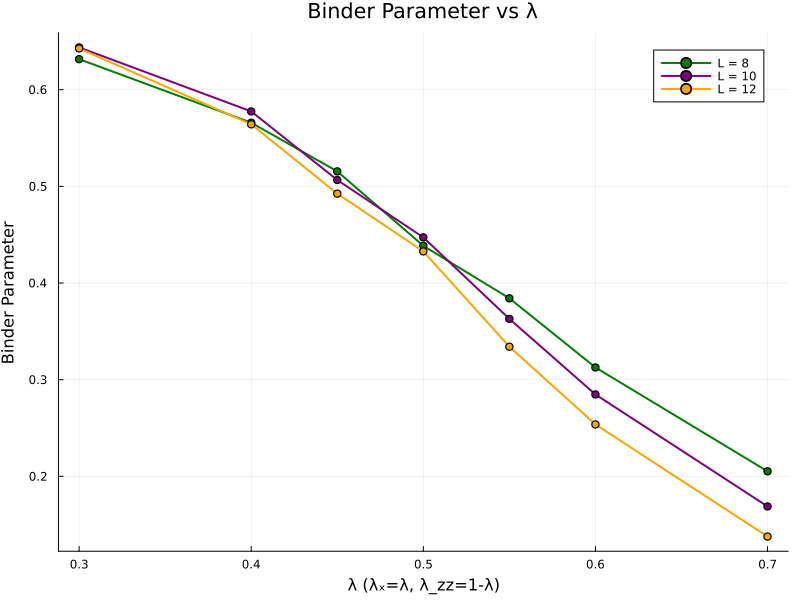


L = 8:
  λ = 0.3: B = 0.63159
  λ = 0.4: B = 0.565842
  λ = 0.45: B = 0.515502
  λ = 0.5: B = 0.438442
  λ = 0.55: B = 0.384174
  λ = 0.6: B = 0.312646
  λ = 0.7: B = 0.205168

L = 10:
  λ = 0.3: B = 0.643734
  λ = 0.4: B = 0.577544
  λ = 0.45: B = 0.506587
  λ = 0.5: B = 0.447189
  λ = 0.55: B = 0.362887
  λ = 0.6: B = 0.284696
  λ = 0.7: B = 0.168842

L = 12:
  λ = 0.3: B = 0.642672
  λ = 0.4: B = 0.564169
  λ = 0.45: B = 0.492432
  λ = 0.5: B = 0.432689
  λ = 0.55: B = 0.334079
  λ = 0.6: B = 0.253677
  λ = 0.7: B = 0.137688


In [16]:
plt_combined = plot(title="Binder Parameter vs λ", 
                   xlabel="λ (λₓ=λ, λ_zz=1-λ)", ylabel="Binder Parameter",
                   grid=true, size=(800, 600))

colors = [:red, :green, :purple, :orange]

for (i, L) in enumerate(L_values)
    data = results[i]
    color = colors[i % length(colors) + 1]
    
    # Filter out any NaN values
    valid_idx = findall(!isnan, data.B)
    if !isempty(valid_idx)
        plot!(plt_combined, data.λs[valid_idx], data.B[valid_idx],
              marker=:circle, markersize=4, linewidth=2,
              label="L = $L", color=color)
    end
end

display(plt_combined)

println("="^50)
for (i, L) in enumerate(L_values)
    data = results[i]
    println("\nL = $L:")
    for (j, λ) in enumerate(data.λs)
        B_val = data.B[j]
        println("  λ = $(round(λ, digits=3)): B = $(round(B_val, digits=6))")
    end
end